In [2]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from scipy.special import logsumexp


import itertools
from collections import defaultdict
import collections

from functools import reduce

from multiprocess import Pool
from functools import partial
import numpy as np

import itertools 
from itertools import islice
import games

import cpb
import bpm
import random_algo

import plotly.graph_objects as go
import TSPM

import cpb_gaussian
import PM_DMED
import feedexp3_piccolboni

def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type):

    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type)

    np.random.seed(1)
    distributions = []

    for jobid in range(n_folds):
        
        if type == 'easy' :
            p = np.random.uniform(0, 0.2) if np.random.uniform(0,1)>0.5 else np.random.uniform(0.8, 1)
        #elif type == 'easy' and jobid > 100:
        #    p = np.random.uniform(0.8, 1)
        else:
            p = np.random.uniform(0.4,0.6)
        distributions.append( [p, 1-p] )

    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions ,range(n_folds)) ) ) 

class Evaluation:

    def __init__(self, horizon, type ):
        self.horizon = horizon
        self.type = type
        # self.outcome_distribution = outcome_distribution

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, jobid = job

        #print('seed {} distribution {}'.format(jobid, distribution)) 
        np.random.seed(jobid)
        
        # outcome_distribution =  {'spam':0.05,'ham':0.95}

        outcome_distribution = {'spam':distribution[0],'ham':distribution[1]}

        # p = get_easy() if game.mode == 'easy' else get_harsch() 
        # outcome_distribution =  {'a':p[0],'b':p[1],'c':p[2],'d':p[3],'e':p[4]}

        game.set_outcome_distribution( outcome_distribution, jobid )
        optimal_action = game.i_star

        action_counter = np.zeros( (game.n_actions, self.horizon) )
        cum_regret = []

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)
        # outcomes, summary = self.distribution_shift(game )

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]

            # print('t', t, 'action', action, 'outcome', outcome, )

            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, None, t)
            
            # print('nu', alg.nu / alg.n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] + 1
                else:
                    
                    action_counter[i][t] = action_counter[i][t-1]

        # regret = []
        # for t in range(self.horizon):
        #     regret.append(  self.delta_t( game, summary, t )  @ action_counter[:,t] )
            # cum_regret.append(  game.LossMatrix[action,outcome] - min( game.LossMatrix[...,outcome ] )  )
            
        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter
        
        return regret #np.cumsum(cum_regret)

In [3]:
n_cores = 16
n_folds = 100
horizon = 100000

# game = games.apple_tasting(False)

# algos = [   PM_DMED.PM_DMED(  game, horizon, 1),  ] 
# colors = [  [250,0,250] , ] 
# labels = [  'PM_DMED',    ] 

# for alg, color, label in zip( algos, colors, labels):
#     result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'hard')
#     np.save('./results/apple_tasting/hard_{}_{}_{}'.format(horizon,n_folds, label), result)


# for alg, color, label in zip( algos, colors, labels):
#     result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
#     np.save('./results/apple_tasting/easy_{}_{}_{}'.format(horizon,n_folds, label), result)


game = games.label_efficient(  )

algos = [   random_algo.Random(  game, horizon, ),

            feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10), 

            PM_DMED.PM_DMED(  game, horizon, 100),
            PM_DMED.PM_DMED(  game, horizon, 10), 
            PM_DMED.PM_DMED(  game, horizon, 1),   
            PM_DMED.PM_DMED(  game, horizon, 0.1), 

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 

colors = [  [0,0,0], [250,0,0], [0,250,0], [0,125,0], [250,0,250], [200,0,200], [150,0,150], [100,0,100], [0,0,250], [0,0,125],  [0,125,125]  ]
labels = [   'random', 'Piccolboni','CBP', 'RandCBP', 'PM_DMEDc100', 'PM_DMEDc10', 'PM_DMEDc1', 'PM_DMEDc01', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ] 

for alg, color, label in zip( algos, colors, labels):

    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'harsch')
    np.save('./results/label_efficient/hard_{}_{}_{}'.format(horizon,n_folds, label), result)


for alg, color, label in zip( algos, colors, labels):
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    np.save('./results/label_efficient/easy_{}_{}_{}'.format(horizon,n_folds, label), result)



Restricted license - for non-production use only - expires 2023-10-25
weights [1. 0. 0.]
n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbCores: 16 nbFolds: 100 Horizon: 100000
nbC

In [7]:


n_cores = 1
n_folds = 1
horizon = 110

# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 

outcome_distribution = [0.1077633468006714, 0.8922366531993287]
job = (outcome_distribution, 9 )

game =  games.label_efficient(  ) 
game.set_outcome_distribution( {'spam':outcome_distribution[0],'ham':outcome_distribution[1]} )
print('optimal action', game.i_star)

# print('optimal action', game.i_star)
alg = PM_DMED.PM_DMED(  game, horizon, 10) #cpb.CPB(  game, horizon,1.01) #TSPM.TSPM_alg(  game, horizon, 1)
task = Evaluation(horizon, 'harsch')

result = task.eval_policy_once(alg,game, job)
#plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


optimal action 1
n-actions 3 n-outcomes 2 alphabet 3
t 0 action 0 outcome 0
not in True
counter False
ZR {1, 2} counter 4.0 threshold 0.0
not in False
counter False
ZR {1, 2} counter 3.0 threshold 0.0
not in False
counter False
ZR {1, 2} counter 3.0 threshold 0.0
Objective value at iteration #0 is - 2.10963
Objective value at iteration #1 is - 1.94743
Objective value at iteration #2 is - 1.93973
Objective value at iteration #3 is - 1.93973
Objective value at iteration #4 is - 1.93973
insufficient actions [1, 2]
t 1 action 1 outcome 1
not in True
counter True
ZR {2} counter 4.0 threshold 8.32554611157698
forced exploration of 0
not in True
counter True
ZR {2} counter 4.0 threshold 8.32554611157698
forced exploration of 1
not in False
counter True
ZR {2} counter 3.0 threshold 8.32554611157698
Objective value at iteration #0 is - 1.82195
Objective value at iteration #1 is - 1.65974
Objective value at iteration #2 is - 1.65205
Objective value at iteration #3 is - 1.65205
Objective value at

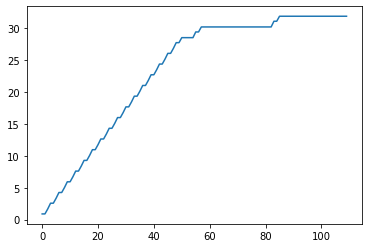

In [8]:
plt.plot(result)

In [5]:
n_cores = 16
n_folds = 100
horizon = 5000

game = games.label_efficient(  )

algos = [   random_algo.Random(  game, horizon, ),
            PM_DMED.PM_DMED(  game, horizon, 1),   
            PM_DMED.PM_DMED(  game, horizon, 0.5),   
            PM_DMED.PM_DMED(  game, horizon, 0.1),   
            PM_DMED.PM_DMED(  game, horizon, 0.01)      ] 

colors = [  [0,0,0],  [250,0,250], [200,0,200], [150,0,150], [100,0,100]   ]
labels = [   'random', 'PM_DMED (c = 1)', 'PM_DMED (c = 0.5)', 'PM_DMED (c = 0.1)', 'PM_DMED (c = 0.01)'   ] 

fig = go.Figure( )

final_regrets = []

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'harsch')
    # result = np.load('./results/label_efficient/pm_dmed/hard_{}_{}_{}.npy'.format(horizon,n_folds, label) )
    final_regrets.append( result[:,-1] )
    regret =  np.mean(result, 0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    np.save('./results/label_efficient/pm_dmed/hard_{}_{}_{}'.format(horizon,n_folds, label), result)

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )  )
    
# fig.show(legend=True)
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                  xaxis_title="Sequence", yaxis_title="Regret",  margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ),   font=dict(size=13,) )
fig.write_image("./results/label_efficient/pm_dmed/hard_LE.pdf")

fig.show()

fig.update_xaxes(type="log")
fig.write_image("./results/label_efficient/pm_dmed/hard_LE_log.pdf")
fig.show()
final_regrets = np.array(final_regrets)
final = [ ( np.argmin(final_regrets[:,i]), i) for i in range(n_folds) ]

n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
n-actions 3 n-outcomes 2 alphabet 3
nbCores: 16 nbFolds: 100 Horizon: 5000
nbCores: 16 nbFolds: 100 Horizon: 5000
nbCores: 16 nbFolds: 100 Horizon: 5000


Process ForkPoolWorker-200:
Process ForkPoolWorker-204:
Process ForkPoolWorker-198:
Traceback (most recent call last):
Process ForkPoolWorker-196:
Process ForkPoolWorker-203:
Traceback (most recent call last):
  File "/home/mheuillet/anaconda3/envs/climate-ai/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-195:
Traceback (most recent call last):
Process ForkPoolWorker-208:
Traceback (most recent call last):
  File "/home/mheuillet/anaconda3/envs/climate-ai/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mheuillet/anaconda3/envs/climate-ai/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mheuillet/anaconda3/envs/climate-ai/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run(

KeyboardInterrupt: 

  File "/tmp/ipykernel_30148/2531667574.py", line 110, in eval_policy_once
    alg.update(action, feedback, outcome, None, t)
  File "/tmp/ipykernel_30148/2531667574.py", line 110, in eval_policy_once
    alg.update(action, feedback, outcome, None, t)
  File "/home/mheuillet/Desktop/attack_detection/partial_monitoring/PM_DMED.py", line 132, in insufficientActions
    #print('t', t)
  File "/tmp/ipykernel_30148/2531667574.py", line 110, in eval_policy_once
    alg.update(action, feedback, outcome, None, t)
  File "/home/mheuillet/Desktop/attack_detection/partial_monitoring/PM_DMED.py", line 269, in feedback_idx
    idx = 0
  File "/home/mheuillet/Desktop/attack_detection/partial_monitoring/PM_DMED.py", line 68, in update
    for j in range(self.N):
KeyboardInterrupt
  File "/home/mheuillet/Desktop/attack_detection/partial_monitoring/PM_DMED.py", line 207, in sufficientExploration
  File "/home/mheuillet/Desktop/attack_detection/partial_monitoring/PM_DMED.py", line 203, in sufficientExpl